# 패키지 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from tqdm import tqdm_notebook

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 이해하기

### 목표 : 은행 신용 카드 서비스 이탈 고객 예측 모델 만들기!

## 칼럼 설명

- feature
 - Customer_Age : 고객의 나이
 - Gender : 성별 (M=Male, F=Female)
 - Dependent_count : 부양하는 가족의 수
 - Education_Level : 고객의 최종 학력 (example: high school, college graduate, etc.)
 - Marital_Status : 결혼 상태 (Married, Single, Divorced, Unknown)
 - Income_Category : 소득 범주 (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, etc.)
 - Card_Category : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
 - Months_on_book : Period of relationship with bank
 - Total_Relationship_Count : Total no. of products held by the customer 고객이 보유한 상품 수
 - Months_Inactive_12_mon : No. of months inactive in the last 12 months 지난 12개월 동안 비활성화 개월 수
 - Contacts_Count_12_mon : No. of Contacts in the last 12 months
 - Credit_Limit : Credit Limit on the Credit Card
 - Total_Revolving_Bal : Total Revolving Balance on the Credit Card
 - Avg_Open_To_Buy : Open to Buy Credit Line (Average of last 12 months)
 - Total_Amt_Chng_Q4_Q1 : Change in Transaction Amount (Q4 over Q1)
 - Total_Trans_Amt : Total Transaction Amount (Last 12 months)
 - Total_Trans_Ct : Total Transaction Count (Last 12 months)
 - Total_Ct_Chng_Q4_Q1 : Change in Transaction Count (Q4 over Q1)
 - Avg_Utilization_Ratio : Average Card Utilization Ratio

- target
 - Attrition_Flag : 고객 활동 변수 / Existing Customer - 0, Attrited Customer - 1
1. 은행 카드 서비스 담당자의 입장

2. 카드 서비스를 이용하는 고객의 입장

위 두 가지를 생각하면서 데이터를 분석하는 것은 어떨까요??

데이터 출처: https://www.kaggle.com/sakshigoyal7/credit-card-customers

## 평가방식

평가방식은 Logloss이기 때문에 predict_proba을 통해서 각 클래스의 예측 확률을 구하는 방식으로 에측을 해야합니다!

## 대회 주소
https://www.kaggle.com/t/cd058141be084c4f81c9df010c587ae4

In [ ]:
# 데이터의 경로 각자에 맞추어서 변경해주세요

train = pd.read_csv('/content/drive/MyDrive/Tobigs/week4_Ensemble_Assignment/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Tobigs/week4_Ensemble_Assignment/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Tobigs/week4_Ensemble_Assignment/sample_submission.csv')

In [ ]:
train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,44,F,1,Unknown,Divorced,Unknown,Blue,36,3,2,1,17116.0,1289,15827.0,0.559,3632,50,0.923,0.075,0
1,42,M,3,Uneducated,Single,$60K - $80K,Blue,30,4,2,3,8302.0,1294,7008.0,0.558,3221,66,0.610,0.156,0
2,57,M,0,Uneducated,Divorced,$80K - $120K,Blue,39,4,4,3,2795.0,1832,963.0,0.839,4679,67,0.861,0.655,0
3,26,F,1,Graduate,Single,$40K - $60K,Blue,20,6,3,3,1438.3,673,765.3,0.595,2167,48,0.412,0.468,0
4,38,F,0,Uneducated,Married,Less than $40K,Blue,26,5,1,4,2230.0,0,2230.0,0.896,3766,63,0.909,0.000,0


In [ ]:
test.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,53,F,2,College,Single,Less than $40K,Blue,45,6,3,3,6210.0,1083,5127.0,0.621,3095,62,0.590,0.174
1,52,M,1,College,Married,$80K - $120K,Blue,48,4,3,3,2066.0,1601,465.0,0.742,1578,41,0.414,0.775
2,27,M,0,Unknown,Married,$40K - $60K,Blue,14,4,1,4,3823.0,2130,1693.0,0.371,2026,49,0.441,0.557
3,43,M,3,Unknown,Single,$60K - $80K,Blue,34,6,2,0,13771.0,2517,11254.0,0.501,1510,42,0.750,0.183
4,55,F,2,High School,Married,$40K - $60K,Blue,42,2,2,3,5431.0,2007,3424.0,0.661,4569,82,0.608,0.370


In [ ]:
submission.head()

,id,Existing Customer,Attrited Customer
0,0,0,1
1,1,0,1
2,2,0,1
3,3,0,1
4,4,0,1


# 데이터 전처리


In [ ]:
train.shape

(8101, 20)

In [ ]:
test.shape

(2026, 19)

In [ ]:
train.isna().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Attrition_Flag              0
dtype: int64

In [ ]:
test.isna().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

데이터에 결측치는 존재하지 않는 것으로 보입니다.

하지만 진짜 결측치가 존재하지 않을까요?

결측치가 다른 이름으로 기록되어 있을 수도 있고 0으로 기록되어 있을 수도 있습니다.

이 부분은 한번 EDA를 통해서 확인해보세요!

# EDA

정형데이터의 경우 feature engineering 이 모델의 성능에 정말 큰 영향을 주기 때문에 EDA를 통해서 얻은 인사이트를 바탕으로 최고의 feature를 만들어보세요! 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Gender                    8101 non-null   object 
 2   Dependent_count           8101 non-null   int64  
 3   Education_Level           8101 non-null   object 
 4   Marital_Status            8101 non-null   object 
 5   Income_Category           8101 non-null   object 
 6   Card_Category             8101 non-null   object 
 7   Months_on_book            8101 non-null   int64  
 8   Total_Relationship_Count  8101 non-null   int64  
 9   Months_Inactive_12_mon    8101 non-null   int64  
 10  Contacts_Count_12_mon     8101 non-null   int64  
 11  Credit_Limit              8101 non-null   float64
 12  Total_Revolving_Bal       8101 non-null   int64  
 13  Avg_Open_To_Buy           8101 non-null   float64
 14  Total_Am

In [ ]:
8101 + 2026

10127

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              2026 non-null   int64  
 1   Gender                    2026 non-null   object 
 2   Dependent_count           2026 non-null   int64  
 3   Education_Level           2026 non-null   object 
 4   Marital_Status            2026 non-null   object 
 5   Income_Category           2026 non-null   object 
 6   Card_Category             2026 non-null   object 
 7   Months_on_book            2026 non-null   int64  
 8   Total_Relationship_Count  2026 non-null   int64  
 9   Months_Inactive_12_mon    2026 non-null   int64  
 10  Contacts_Count_12_mon     2026 non-null   int64  
 11  Credit_Limit              2026 non-null   float64
 12  Total_Revolving_Bal       2026 non-null   int64  
 13  Avg_Open_To_Buy           2026 non-null   float64
 14  Total_Am

In [ ]:
train.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
count,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000,8101.000000
mean,46.291199,2.339958,35.905938,3.808172,2.347241,2.460931,8667.346587,1157.653746,7509.692840,0.760068,4444.729663,64.984199,0.711699,0.274665,0.160721
std,8.040300,1.300795,8.011260,1.553566,1.013624,1.098309,9127.897938,815.062550,9129.855775,0.218224,3448.702344,23.608677,0.235800,0.277166,0.367296
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,563.000000,10.000000,0.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2557.000000,289.000000,1316.000000,0.631000,2169.000000,45.000000,0.583000,0.020000,0.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1273.000000,3508.000000,0.737000,3904.000000,67.000000,0.700000,0.173000,0.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11135.000000,1781.000000,9930.000000,0.859000,4754.000000,81.000000,0.818000,0.504000,0.000000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,138.000000,3.714000,0.999000,1.000000


In [ ]:
train.describe(include='object')

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,8101,8101,8101,8101,8101
unique,2,7,4,6,4
top,F,Graduate,Married,Less than $40K,Blue
freq,4286,2535,3749,2848,7546


In [ ]:
numerical = train.select_dtypes(exclude=['object']).columns.tolist()
numerical.remove('Attrition_Flag')

categorical = train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print('numerical features:', len(numerical))
print('categorical features:', len(categorical))

numerical features: 14
categorical features: 3


### 1. Box plot

In [ ]:
for col in numerical:
  fig = px.box(train, color="Attrition_Flag", y=col, points="all")
  fig.show()

### 2.Dist plot

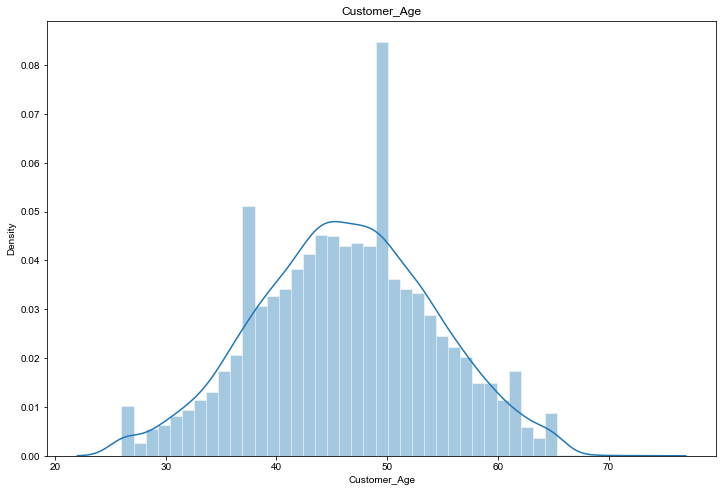

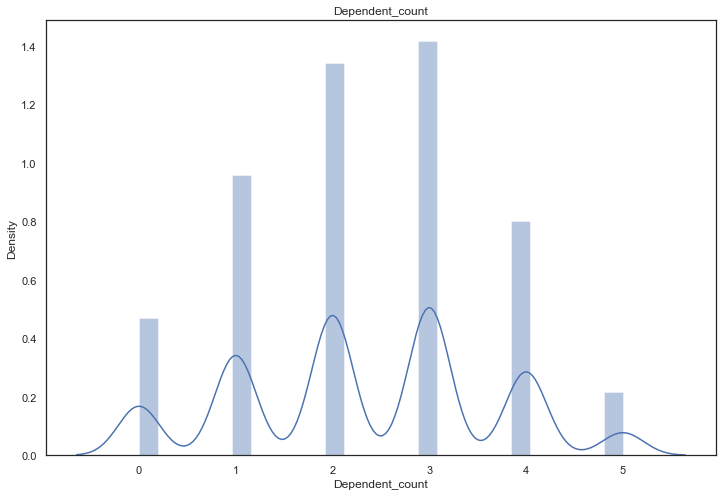

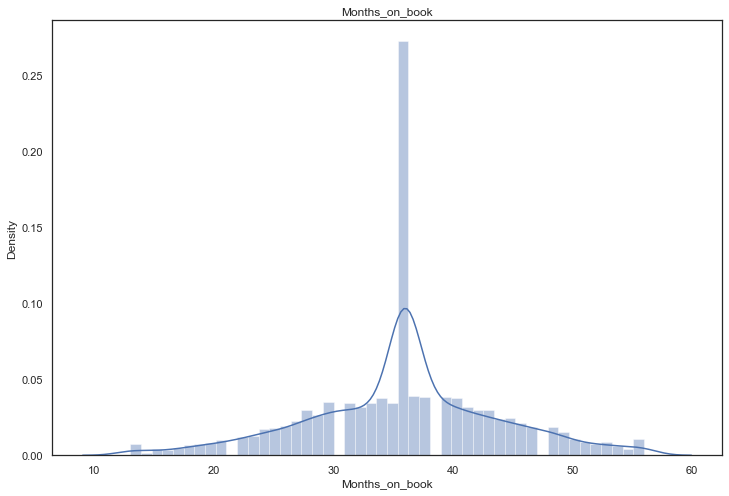

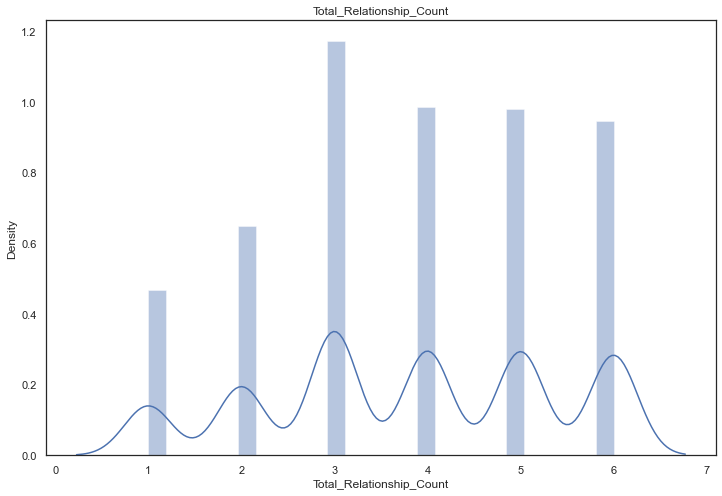

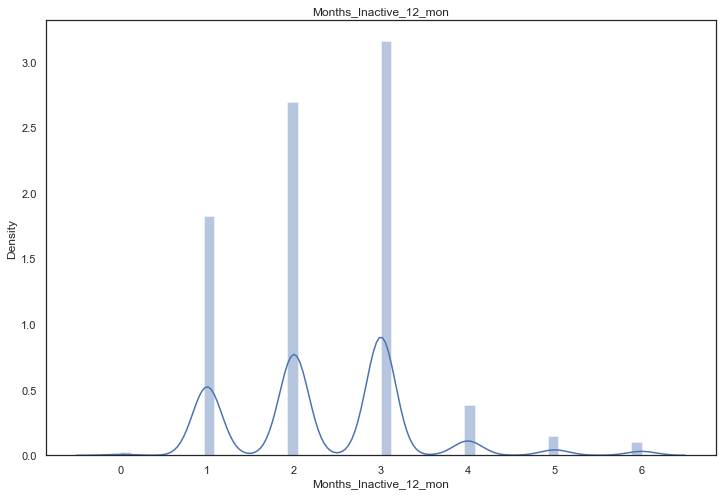

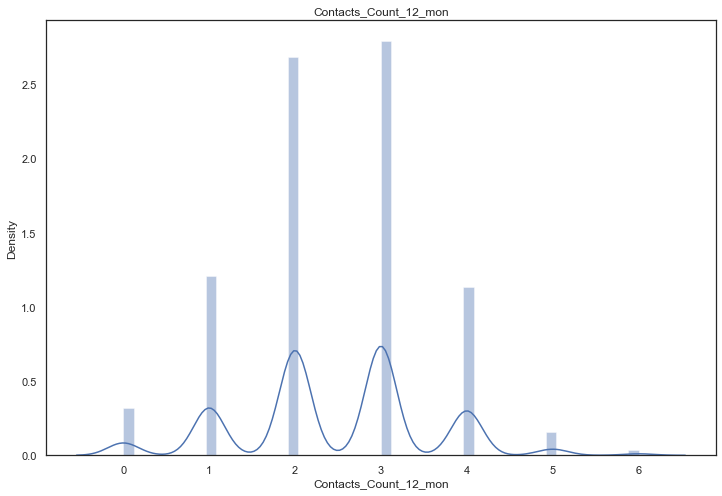

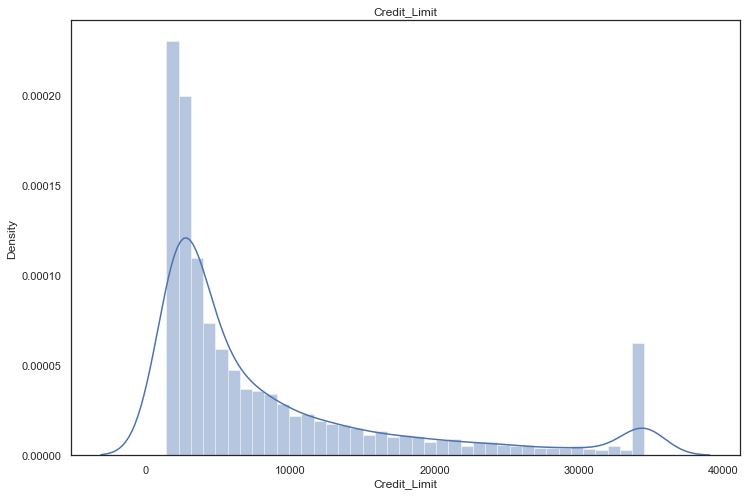

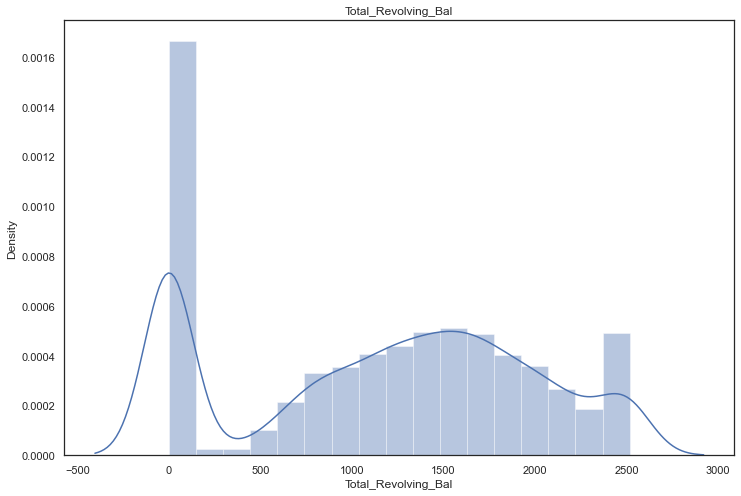

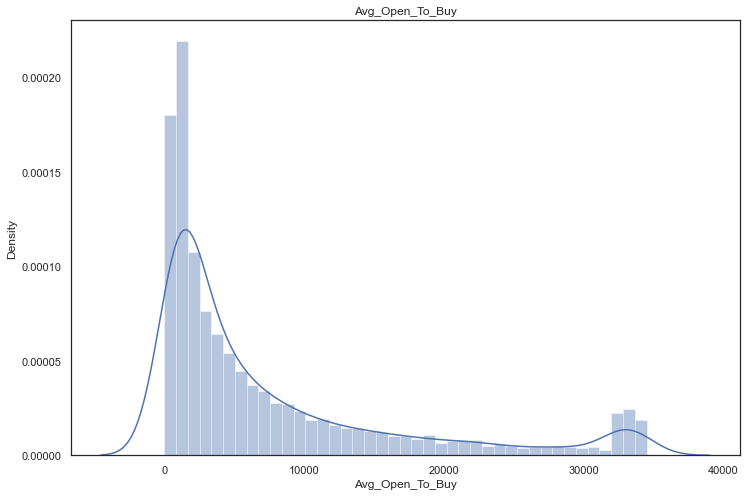

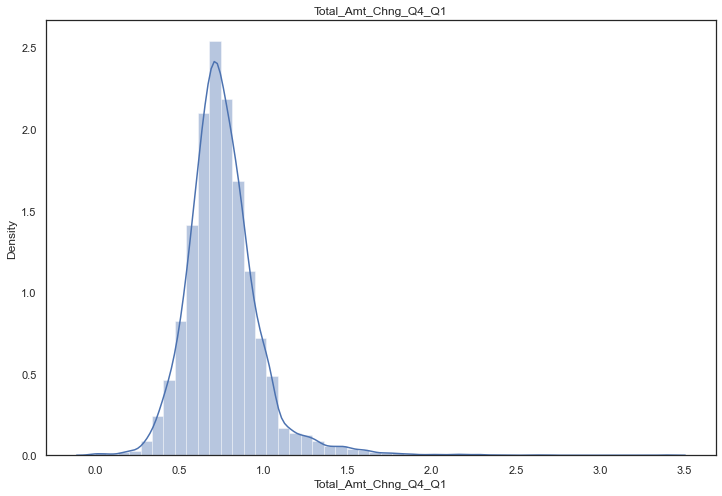

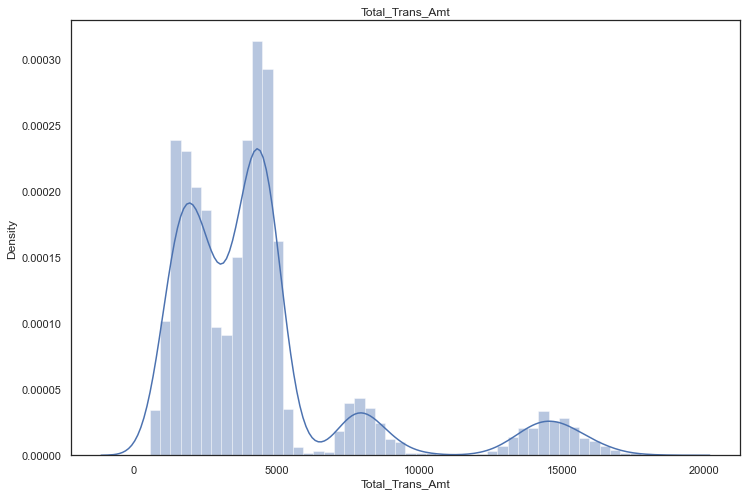

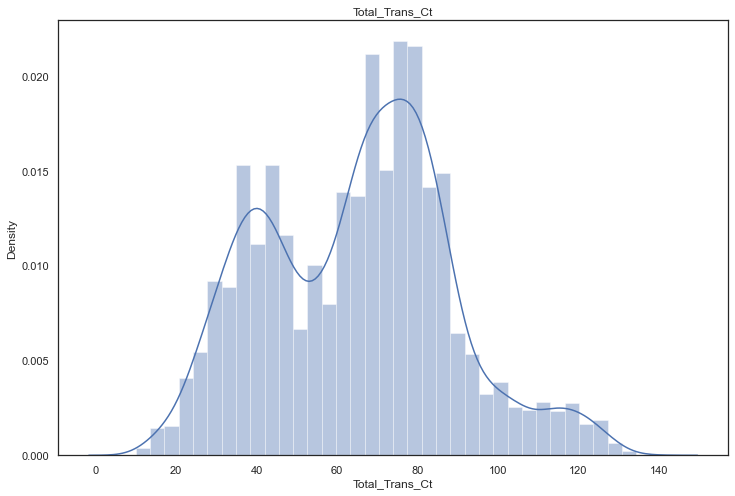

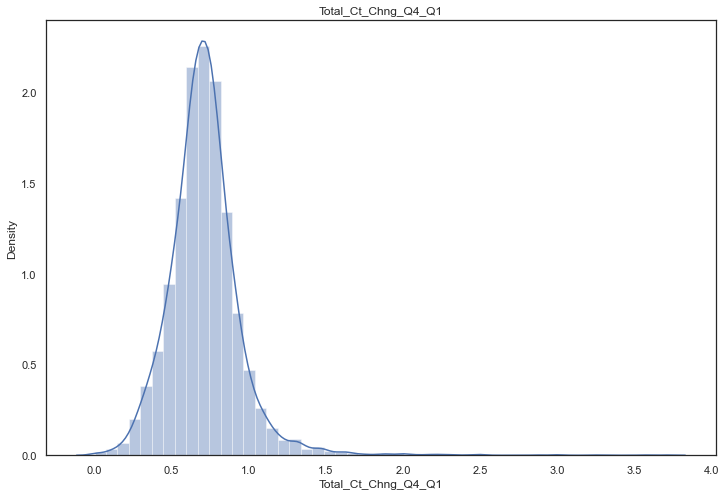

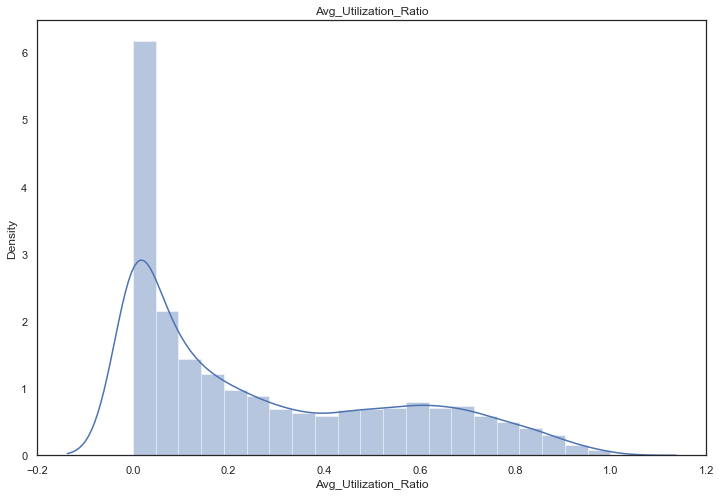

In [ ]:
for col in numerical:
    fig, ax = plt.subplots(figsize=(12,8))
    plt.title(col)
    sns.set(style='white')
    sns.distplot(train[col], ax=ax)

### 1. countplot

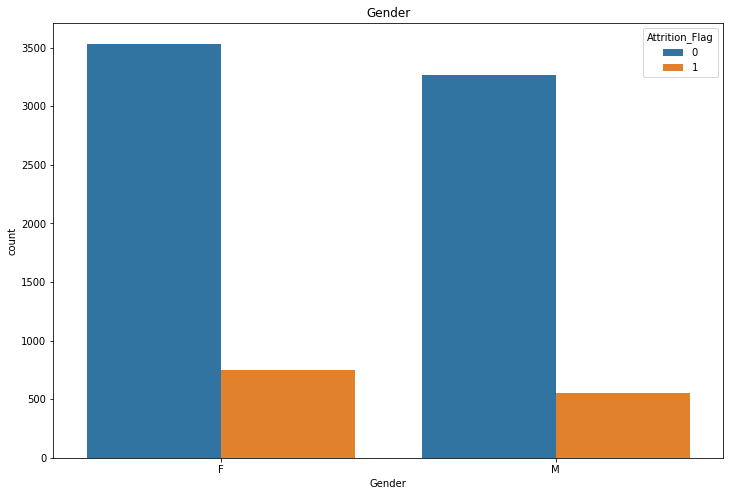

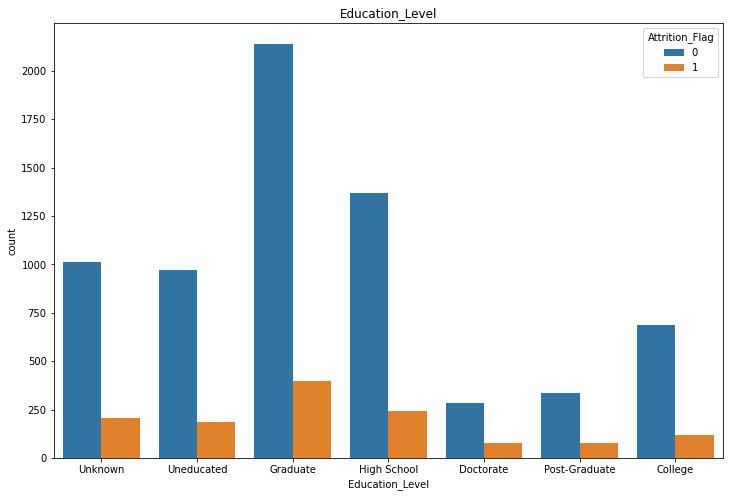

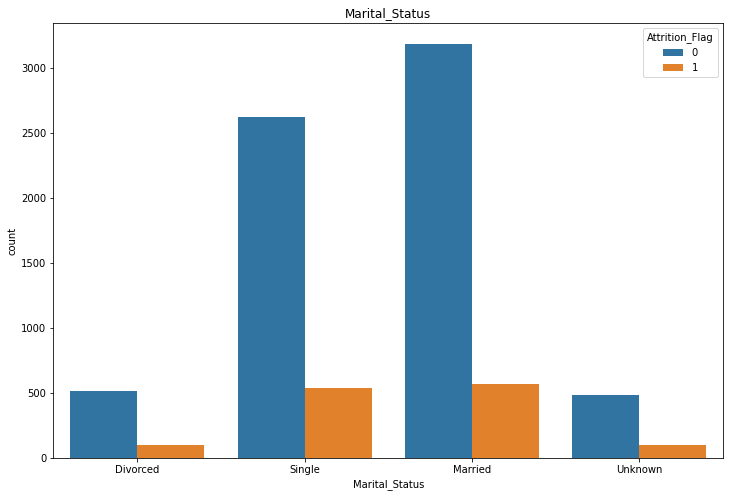

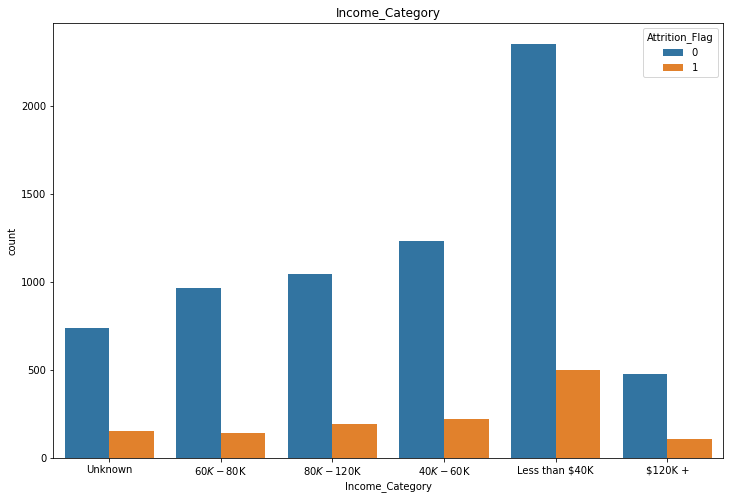

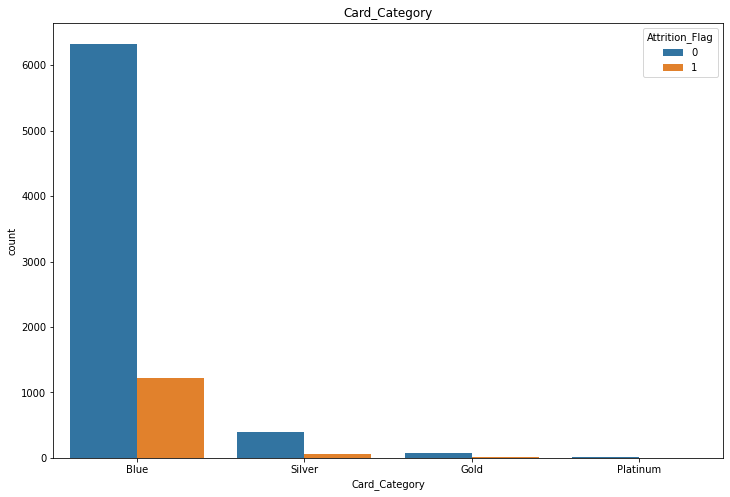

In [ ]:
for col in categorical:
    fig, ax = plt.subplots(figsize=(12,8))
    plt.title(col)
    sns.countplot(train[col], ax=ax, hue = train['Attrition_Flag'])

In [ ]:
train.groupby(['Attrition_Flag',"Gender","Card_Category"]).agg({"Credit_Limit":"mean"})

Credit_Limit
Attrition_Flag Gender Card_Category              
0              F      Blue            4416.418802
                      Gold           20119.095238
                      Platinum       29883.750000
                      Silver         19070.156863
               M      Blue           10968.341353
                      Gold           31536.942308
                      Platinum       34516.000000
                      Silver         29325.085106
1              F      Blue            3938.771330
                      Gold           20603.571429
                      Platinum       28339.666667
                      Silver         16433.850000
               M      Blue           11173.566129
                      Gold           34516.000000
                      Platinum       23981.000000
                      Silver         29852.023256

In [ ]:
!pip install plotly==4.5.2

     |████████████████████████████████| 7.1 MB 5.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import plotly.express as px

df = px.data.tips()
fig = px.sunburst(train, path=['Attrition_Flag', 'Gender', 'Card_Category'])
fig.show()

Blue 등급 카드를 사용하는 여성 이탈 고객이 가장 많다.

## Correlation

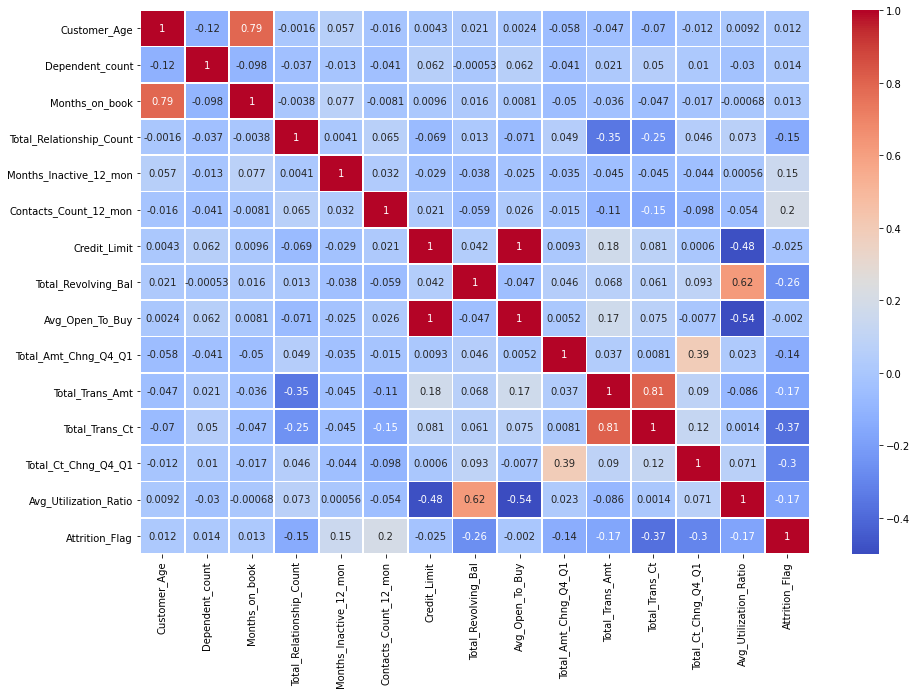

In [ ]:
corr= train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,annot= True,vmin=-0.5,vmax=1, cmap='coolwarm',linewidths=0.75)
plt.show()

* 양의 상관관계: (Months_on_book, Customer_Age) , (Avg_Open_To_Buy, Credit_Limit), (Avg_Utilization_Ratio, Total_Revolving_Bal), (Total_Trans_Amt, Total_Trans_Ct)
* 음의 상관관계: (Avg_Utilization_Ratio, Avg_Open_To_Buy), (Avg_Utilization_Ratio, Credit_Limit)

## 결측치 처리

unknown == 결측치

In [ ]:
print('Education_Level 결측 비율:', round(len(train[train['Education_Level'] == 'Unknown']) / len(train['Education_Level']) * 100,3))
print('Marital_Status 결측 비율:', round(len(train[train['Marital_Status'] == 'Unknown']) / len(train['Marital_Status']) * 100,3))
print('Income_Category 결측 비율:', round(len(train[train['Income_Category'] == 'Unknown']) / len(train['Income_Category']) * 100,3))

Education_Level 결측 비율: 15.06
Marital_Status 결측 비율: 7.209
Income_Category 결측 비율: 10.949


결측치가 10% 이상인 변수 삭제
* Education_Level, Income_Category 변수 삭제

In [ ]:
train = train.drop(['Education_Level','Income_Category'],axis='columns',inplace=False)

In [ ]:
test = test.drop(['Education_Level','Income_Category'],axis='columns',inplace=False)

결측치가 10% 이하인 변수의 결측치 대체
* Marital_Status 결측치 최빈값으로 대체

In [ ]:
print('Marital_Status의 최빈값:','\n', train['Marital_Status'].mode())

Marital_Status의 최빈값: 
 0    Married
dtype: object


In [ ]:
len(train[train['Marital_Status']=='Married'])

3749

In [ ]:
train['Marital_Status'] = train['Marital_Status'].replace('Unknown', 'Married')
train['Marital_Status'].unique()

array(['Divorced', 'Single', 'Married'], dtype=object)

In [ ]:
test['Marital_Status'] = test['Marital_Status'].replace('Unknown', 'Married')
test['Marital_Status'].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

In [ ]:
len(train[train['Marital_Status']=='Married'])

4333

결측치 처리를 하지 않았을 때의 성능이 더 좋았으므로 최종 모델에는 결측치 처리를 하지 않았다. 


> **결측치 처리 X**



## Scaling & One-Hot Encoding

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
def pipeline(df, nums, cats):
    
    num_pipeline=Pipeline([
        ("select_numeric",DataFrameSelector(nums)),
        ("scaler", StandardScaler())])

    cat_pipeline = Pipeline([
        ("select_cat",DataFrameSelector(cats)),
        ("encoder", OneHotEncoder())])
    
    preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)])
    
    X=preprocess_pipeline.fit_transform(df)
    X=preprocess_pipeline.fit_transform(df)
    
    return X

In [ ]:
X_train = pipeline(train, numerical, categorical)
print(X_train.shape)

(8101, 23)


In [ ]:
X_test = pipeline(test, numerical, categorical)
print(X_test.shape)

(2026, 23)


In [ ]:
train['Attrition_Flag'].astype('object')

0       0
1       0
2       0
3       0
4       0
       ..
8096    0
8097    0
8098    0
8099    0
8100    0
Name: Attrition_Flag, Length: 8101, dtype: object

In [ ]:
y_train = train['Attrition_Flag']

## LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

cat_cols = test.dtypes[test.dtypes == 'O'].index.tolist()

lbl = LabelEncoder()

# 원본데이터의 변형을 막고자 데이터를 copy함
temp_train = train.copy()
temp_test = test.copy()

for col in tqdm_notebook( cat_cols ):
  # local_train과 local_test를 concat하여 temp_df에 저장
  temp_df = pd.concat([ temp_train[[col]], temp_test[[col]] ] , axis=0)
  
  # Label-Encoding을 fitting함
  lbl.fit( temp_df[col] )
  
  # local_train/local_test에 label_encoding한 값을 대입함
  temp_train[col] = lbl.transform(temp_train[col])
  temp_test[col] = lbl.transform(temp_test[col])

features = test.columns.tolist()
target = 'Attrition_Flag'

X_train = temp_train[features]
y_train = temp_train[target]

X_test = temp_test[features]

* One-Hot Encoder를 사용하였을 때보다 LabelEncoder를 하였을 때 성능이 더 좋았으므로 최종 모델에는 라벨인코딩을 사용하였다. <br>
* 수치형 변수를 Scaling하지 않았을 때의 성능이 더 좋았으므로 최종 모델에 scaling을 하지 않았다. <br>

> **LabelEncoding**, **Scaling X**




## SMOTE

In [ ]:
print("# existing customers: {}\n".format(len(train[train['Attrition_Flag']  == 0])))
print("# attrited customers: {}\n".format(len(train[train['Attrition_Flag']  == 1])))

# existing customers: 6799

# attrited customers: 1302



In [ ]:
df = px.data.tips()
fig = px.sunburst(train, path=['Attrition_Flag'], title='Attrition_Flag')
fig.show()

데이터 불균형이 있음을 확인.<br>
=> SMOTE로 해결

In [ ]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 16, stratify = y_train)

In [ ]:
# Train Dataset에 SMOTE 적용
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
train_X_over,train_y_over = smote.fit_sample(train_X,train_y)

In [ ]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', train_X.shape, train_y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', train_X_over.shape, train_y_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(train_y_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (6480, 23) (6480,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (10878, 23) (10878,)
SMOTE 적용 후 레이블 값 분포: 
 1    5439
0    5439
dtype: int64


SMOTE를 적용하지 않은 데이터셋을 사용하였을 때의 성능이 월등히 좋았으므로 SMOTE를 적용하지 않았다.


> **SMOTE X**



# Model

저는 라벨인코딩만을 이용한 간단한 베이스 라인 모델을 만들었습니다.

16기 분들은 feature engineering, 하이퍼 파라미터 튜닝, 앙상블 등 다양한 방법으로 성능이 우수한 모델을 만들어보세요!

## 1. Voting

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state = 16)
dt_clf = DecisionTreeClassifier(random_state = 16, max_depth = None)
svm_clf = SVC(probability = True, random_state = 16) # 클래스의 예측 확률을 구하기 위해서

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('dt', dt_clf), ('svm', svm_clf)],
    voting = 'soft'
)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

for clf in [log_clf, dt_clf, svm_clf, voting_clf]:
    clf.fit(train_X, train_y)
    y_pred = clf.predict_proba(val_X)
    print(clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
    print(clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))
    print()

LogisticRegression Logloss Score: 0.22242746451218642
LogisticRegression Accuracy Score: 0.9086983343615053

DecisionTreeClassifier Logloss Score: 2.2585504613575162
DecisionTreeClassifier Accuracy Score: 0.9346082665021591

SVC Logloss Score: 0.15944155629738418
SVC Accuracy Score: 0.932140653917335

VotingClassifier Logloss Score: 0.1480828450222519
VotingClassifier Accuracy Score: 0.9531153608883405



#### CV

In [ ]:
for clf in [log_clf, dt_clf, svm_clf, voting_clf]:
  cv(clf)

LogisticRegression cv mean score: 0.23734303046226826
LogisticRegression cv min score: 0.22090140370969127


DecisionTreeClassifier cv mean score: 2.2468894385352502
DecisionTreeClassifier cv min score: 2.0254220725410597


SVC cv mean score: 0.1635120205831121
SVC cv min score: 0.14294348623622358


VotingClassifier cv mean score: 0.1519250309453579
VotingClassifier cv min score: 0.13784097860971875




## 2. Bagging and Pasting

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt_clf2 = DecisionTreeClassifier(random_state = 16, max_depth = None)

bag_clf = BaggingClassifier(dt_clf2,
                            n_estimators = 500,
                            bootstrap = True, n_jobs = -1) # Bagging

pas_clf = BaggingClassifier(dt_clf2,
                            n_estimators = 500,
                            bootstrap = False, n_jobs = -1) # Pasting

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

for clf in [bag_clf, pas_clf]:
  clf.fit(train_X, train_y)
  y_pred = clf.predict_proba(val_X)
  print(clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
  print(clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))
  print()

BaggingClassifier Logloss Score: 0.10611800619074786
BaggingClassifier Accuracy Score: 0.9666872301048736

BaggingClassifier Logloss Score: 1.6332249169111959
BaggingClassifier Accuracy Score: 0.932757557063541



#### 2) CV

In [ ]:
for clf in [bag_clf, pas_clf]:
  cv(clf)

BaggingClassifier cv mean score: 0.12038948948153408
BaggingClassifier cv min score: 0.10503498198682074


BaggingClassifier cv mean score: 1.6299831313350328
BaggingClassifier cv min score: 1.4398293664858015




## 3. Random Patches Method and Random Subspace Method

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt_clf2 = DecisionTreeClassifier(random_state = 16, max_depth = None)

pas_rpm_clf = BaggingClassifier(dt_clf2,
                            n_estimators = 500,
                            bootstrap = False, max_samples = 1.0,
                            bootstrap_features = False, max_features = 1.0, 
                            n_jobs = -1) # Pasting and Random Patches Method (위와 동일한 모델임)

bag_rsm_clf = BaggingClassifier(dt_clf2,
                            n_estimators = 500,
                            bootstrap = True, max_samples = 1.0,
                            bootstrap_features = True, max_features = 0.8, 
                            n_jobs = -1) # Bagging and Random Subspace Method

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

for clf in [pas_rpm_clf, bag_rsm_clf]:
    clf.fit(train_X, train_y)
    y_pred = clf.predict_proba(val_X)
    print(clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
    print(clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))
    print()

BaggingClassifier Logloss Score: 1.6330446304008537
BaggingClassifier Accuracy Score: 0.9358420727945712

BaggingClassifier Logloss Score: 0.14325613048120536
BaggingClassifier Accuracy Score: 0.9636027143738433



#### CV

In [ ]:
for clf in [pas_rpm_clf, bag_rsm_clf]:
  cv(clf)

BaggingClassifier cv mean score: 1.6300291011416843
BaggingClassifier cv min score: 1.4397502689802946


BaggingClassifier cv mean score: 0.1496007201976504
BaggingClassifier cv min score: 0.14267670681137976




## 4. RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 16, n_estimators = 500, n_jobs = -1)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

rf_clf.fit(train_X, train_y)
y_pred = rf_clf.predict_proba(val_X)
print(rf_clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
print(rf_clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))

RandomForestClassifier Logloss Score: 0.1281198634045849
RandomForestClassifier Accuracy Score: 0.9660703269586675


#### CV

In [ ]:
cv(rf_clf)

RandomForestClassifier cv mean score: 0.13059709425268595
RandomForestClassifier cv min score: 0.12305202716676009




## 5. ExtraTrees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(random_state = 16, n_estimators = 500, n_jobs = -1)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

et_clf.fit(train_X, train_y)
y_pred = et_clf.predict_proba(val_X)
print(et_clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
print(et_clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))

ExtraTreesClassifier Logloss Score: 0.16965611996200183
ExtraTreesClassifier Accuracy Score: 0.9395434916718075


#### cv

In [ ]:
cv(et_clf)

ExtraTreesClassifier cv mean loss: 0.17156395425971013
ExtraTreesClassifier cv min loss: 0.16038738679317815
ExtraTreesClassifier cv mean acc: 0.9309068476249229
ExtraTreesClassifier cv max acc: 0.9475308641975309




## 6. Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# dt_clf2 = DecisionTreeClassifier(random_state = 16, max_depth = 1)

ada_clf = AdaBoostClassifier(base_estimator = dt_clf2,
                             n_estimators = 500,
                             learning_rate = 0.1,
                             random_state = 16)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

ada_clf.fit(train_X, train_y)
y_pred = ada_clf.predict_proba(val_X)
print(ada_clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
print(ada_clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))

AdaBoostClassifier Logloss Score: 0.6389956924634379
AdaBoostClassifier Accuracy Score: 0.9599012954966071


#### CV 

In [ ]:
cv(ada_clf)

AdaBoostClassifier cv mean loss: 0.6379571954017307
AdaBoostClassifier cv min loss: 0.6366523932445564
AdaBoostClassifier cv mean acc: 0.9493827160493827
AdaBoostClassifier cv max acc: 0.9660493827160493




## 7. Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, random_state = 16)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

gb_clf.fit(train_X, train_y)
y_pred = gb_clf.predict_proba(val_X)
print(gb_clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
print(gb_clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))

GradientBoostingClassifier Logloss Score: 0.06985063189816788
GradientBoostingClassifier Accuracy Score: 0.974090067859346


#### CV

In [ ]:
cv(gb_clf)

GradientBoostingClassifier cv mean loss: 0.07785350139430555
GradientBoostingClassifier cv min loss: 0.07567730815920877
GradientBoostingClassifier cv mean acc: 0.9679012345679012
GradientBoostingClassifier cv max acc: 0.9734567901234568




## 8. eXtreme Gradient Boosting and Light Gradient Boosting Machine

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgb_clf = XGBClassifier(random_state = 16,
                        n_estimators = 500)

lgbm_clf = LGBMClassifier(random_state = 16,
                          n_estimators = 500)

#### Tuning X, OOF X

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

for clf in [xgb_clf, lgbm_clf]:
  clf.fit(train_X, train_y)
  y_pred = clf.predict_proba(val_X)
  print(clf.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
  print(clf.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))
  print()

XGBClassifier Logloss Score: 0.07050256675160683
XGBClassifier Accuracy Score: 0.9703886489821099

LGBMClassifier Logloss Score: 0.12287868273447053
LGBMClassifier Accuracy Score: 0.9716224552745218



#### CV

In [ ]:
for clf in [xgb_clf, lgbm_clf]:
  cv(clf)

XGBClassifier cv mean loss: 0.0741583228436184
XGBClassifier cv min loss: 0.0679726286857765
XGBClassifier cv mean acc: 0.9697530864197531
XGBClassifier cv max acc: 0.9746913580246913


LGBMClassifier cv mean loss: 0.12880431246037471
LGBMClassifier cv min loss: 0.10863015646044488
LGBMClassifier cv mean acc: 0.9697530864197531
LGBMClassifier cv max acc: 0.9740740740740741




## 9. Stacking

In [ ]:
train_pred_li = []
val_pred_li = []
test_pred_li = []

for clf in [bag_clf, rf_clf, gb_clf, xgb_clf, lgbm_clf]:
  clf.fit(train_X, train_y)

  y_train_pred = clf.predict_proba(train_X)
  train_pred_li.append(y_train_pred)

  y_val_pred = clf.predict_proba(val_X)
  val_pred_li.append(y_val_pred)

  y_test_pred = clf.predict_proba(X_test)
  test_pred_li.append(y_test_pred)

In [ ]:
stacking_train = np.concatenate(train_pred_li, axis = 1)
stacking_val = np.concatenate(val_pred_li, axis = 1)
stacking_test = np.concatenate(test_pred_li, axis = 1)

In [ ]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(random_state = 16)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

meta_model.fit(stacking_train, train_y)
y_pred = meta_model.predict_proba(stacking_val)
print(meta_model.__class__.__name__,'Logloss Score:' , log_loss(val_y, y_pred))
print(meta_model.__class__.__name__,'Accuracy Score:' , accuracy_score(val_y, np.argmax(y_pred, axis = 1)))

LogisticRegression Logloss Score: 0.11540996773152101
LogisticRegression Accuracy Score: 0.97347316471314


# OOF

In [ ]:
xgb_clf = XGBClassifier(random_state = 16,
                        n_estimators = 500)

In [ ]:
n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)
kf = KFold(n_splits = n_split, shuffle=True, random_state=22)

rf_oof_train = np.zeros(y_train.shape)
lgbm_oof_train = np.zeros(y_train.shape)
xgb_oof_train = np.zeros(y_train.shape)
gb_oof_train = np.zeros(y_train.shape)
bg_oof_train = np.zeros(y_train.shape)

rf_oof_test = np.zeros((X_test.shape[0], ))
lgbm_oof_test = np.zeros((X_test.shape[0], ))
xgb_oof_test = np.zeros((X_test.shape[0], ))
gb_oof_test = np.zeros((X_test.shape[0], ))
bg_oof_test = np.zeros((X_test.shape[0], ))

rf_clf = RandomForestClassifier(random_state = 16, n_estimators = 500, n_jobs = -1)
gb_clf = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, random_state = 16)
xgb_clf = XGBClassifier(random_state = 16,
                        n_estimators = 500)
lgbm_clf = LGBMClassifier(random_state = 16,
                          n_estimators = 500)
dt_clf2 = DecisionTreeClassifier(random_state = 16, max_depth = None)
bag_clf = BaggingClassifier(dt_clf2,
                            n_estimators = 500,
                            bootstrap = True, n_jobs = -1)

rf_loss = []
lgbm_loss = []
xgb_loss = []
gb_loss = []
bg_loss = []

for trn_idx, val_idx in tqdm_notebook(skf.split(X_train, y_train)):
  trn_data, trn_label = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
  val_data, val_label = X_train.iloc[val_idx], y_train.iloc[val_idx]

  # RandomForest
  rf_clf.fit(trn_data, trn_label)
  rf_valid_pred = rf_clf.predict_proba(val_data)
  rf_loss.append(log_loss(val_label, rf_valid_pred))

  rf_test_pred = rf.predict_proba(X_test)
  rf_oof_test_ex += rf_test_pred[:, :1].T.flatten() / n_split
  rf_oof_test_att += rf_test_pred[:, 1:].T.flatten() / n_split

  # LGBM
  lgbm_clf.fit(trn_data, trn_label)
  lgbm_valid_pred = lgbm_clf.predict_proba(val_data)
  lgbm_loss.append(log_loss(val_label, lgbm_valid_pred))

  lgbm_test_pred = lgbm.predict_proba(X_test)
  lgbm_oof_test_ex += lgbm_test_pred[:, :1].T.flatten() / n_split
  lgbm_oof_test_att += lgbm_test_pred[:, 1:].T.flatten() / n_split

  # XGB
  xgb_clf.fit(trn_data, trn_label)
  xgb_valid_pred = xgb_clf.predict_proba(val_data)
  xgb_loss.append(log_loss(val_label, xgb_valid_pred))

  xgb_test_pred = xgb.predict_proba(X_test)
  xgb_oof_test_ex += xgb_test_pred[:, :1].T.flatten() / n_split
  xgb_oof_test_att += xgb_test_pred[:, 1:].T.flatten() / n_split

  # GB
  gb_clf.fit(trn_data, trn_label)
  gb_valid_pred = gb_clf.predict_proba(val_data)
  gb_loss.append(log_loss(val_label, gb_valid_pred))

  gb_test_pred = gb.predict_proba(X_test)
  gb_oof_test_ex += gb_test_pred[:, :1].T.flatten() / n_split
  gb_oof_test_att += gb_test_pred[:, 1:].T.flatten() / n_split

  #BG
  bg_clf.fit(trn_data, trn_label)
  bg_valid_pred = bg_clf.predict_proba(val_data)
  bg_loss.append(log_loss(val_label, bg_valid_pred))

  bg_test_pred = bg.predict_proba(X_test)
  bg_oof_test_ex += bg_test_pred[:, :1].T.flatten() / n_split
  bg_oof_test_att += bg_test_pred[:, 1:].T.flatten() / n_split

In [ ]:
print(np.mean(rf_loss))
print(np.mean(lgbm_loss))
print(np.mean(xgb_loss))
print(np.mean(gb_loss[:5]))
print(np.mean(bg_loss))

0.12600911146199184
0.1315037462696227
0.07331505497910917
0.07505665588537946
0.11330952760836574


log_loss 평균이 가장 작은 xgb 모델을 최종 모델로 채택

#### Tuning 시도

In [ ]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objectiveXGB(trial: Trial, train_X, train_y, val_X, val_y):
  param = {
      'random_state': 16,
      "n_estimators" : trial.suggest_int('n_estimators', 350, 1000),
      'max_depth':trial.suggest_int('max_depth', 3, 16),
      'min_child_weight':trial.suggest_int('min_child_weight', 1, 30),
      'gamma':trial.suggest_int('gamma', 1, 3),
      'learning_rate': 0.01,
      'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
      'nthread' : -1,
      'tree_method': 'gpu_hist',
      'predictor': 'gpu_predictor',
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
      'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] )
  }
  ## 최종 모델: XGB Classifier
  model = XGBClassifier(**param)
  xgb_model = model.fit(train_X, train_y, verbose=False)

  ## Log_Loss 계산
  y_pred = xgb_model.predict_proba(val_X)
  score = log_loss(val_y, y_pred)

  return score

In [ ]:
study = optuna.create_study(direction='minimize',sampler=TPESampler())

study.optimize(lambda trial : objectiveXGB(trial, train_X,  train_y, val_X, val_y), n_trials=50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2021-08-17 10:01:20,668] A new study created in memory with name: no-name-f6d59cf7-f445-47db-8bf9-b986999379bc
[I 2021-08-17 10:01:23,601] Trial 0 finished with value: 0.11247274081207201 and parameters: {'n_estimators': 487, 'max_depth': 5, 'min_child_weight': 13, 'gamma': 3, 'colsample_bytree': 1.0, 'lambda': 0.005543822432555593, 'alpha': 4.5379808946792926, 'subsample': 0.8}. Best is trial 0 with value: 0.11247274081207201.
[I 2021-08-17 10:01:28,425] Trial 1 finished with value: 0.09430675181852657 and parameters: {'n_estimators': 872, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 3, 'colsample_bytree': 0.6, 'lambda': 0.01611321087979236, 'alpha': 4.724935875032197, 'subsample': 0.7}. Best is trial 1 with value: 0.09430675181852657.
[I 2021-08-17 10:01:33,778] Trial 2 finished with value: 0.08675251460552588 and parameters: {'n_estimators': 720, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 3, 'colsample_bytree': 0.7, 'lambda': 0.3751206274309653, 'alpha': 0.5834573964491

Best trial: score 0.07370202608147572,
params {'n_estimators': 946, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 3, 'colsample_bytree': 0.8, 'lambda': 0.0845301340150298, 'alpha': 0.178783462854308, 'subsample': 1.0}


In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

random_state=16, n_estimators=500, 나머지 파라미터는 default인 모델의 성능이 오히려 가장 좋았기 때문에 Tuning을 하지 않음. <br>
optuna를 여러가지 조정하다보면 좋아지겠지만 일단 여기까지..

# 예측

저는 Stacking 사용했지만 16기 분들은 다양한 방식을 활용해서 모델의 성능을 높여주세요!

**최종 모델: XGB Classifier**
- Tuning X
- OOF O

In [ ]:
submission.iloc[:, 1] = xgb_oof_test_ex
submission.iloc[:, 2] = xgb_oof_test_att
submission.to_csv('/content/drive/MyDrive/Tobigs/week4_Ensemble_Assignment/oof_xgb.csv', index = False)
submission.head()

,id,Existing Customer,Attrited Customer
0,0,0.990804,0.009196
1,1,0.996993,0.003007
2,2,0.870069,0.129931
3,3,0.997224,0.002776
4,4,0.999866,0.000134


Kaggel 닉네임: YoonKim1 <br>
score: 0.6594
